In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q imbalanced-learn shap tensorflow joblib

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')


In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/data-bank.csv'

df = pd.read_csv(path)

df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('?', '').str.lower()

print("Loaded shape:", df.shape)
print("Example columns:", df.columns[:20].tolist())
display(df.head())


Loaded shape: (6819, 96)
Example columns: ['bankrupt', 'roa(c)_before_interest_and_depreciation_before_interest', 'roa(a)_before_interest_and_%_after_tax', 'roa(b)_before_interest_and_depreciation_after_tax', 'operating_gross_margin', 'realized_sales_gross_margin', 'operating_profit_rate', 'pre-tax_net_interest_rate', 'after-tax_net_interest_rate', 'non-industry_income_and_expenditure/revenue', 'continuous_interest_rate_(after_tax)', 'operating_expense_rate', 'research_and_development_expense_rate', 'cash_flow_rate', 'interest-bearing_debt_interest_rate', 'tax_rate_(a)', 'net_value_per_share_(b)', 'net_value_per_share_(a)', 'net_value_per_share_(c)', 'persistent_eps_in_the_last_four_seasons']


,bankrupt,roa(c)_before_interest_and_depreciation_before_interest,roa(a)_before_interest_and_%_after_tax,roa(b)_before_interest_and_depreciation_after_tax,operating_gross_margin,realized_sales_gross_margin,operating_profit_rate,pre-tax_net_interest_rate,after-tax_net_interest_rate,non-industry_income_and_expenditure/revenue,...,net_income_to_total_assets,total_assets_to_gnp_price,no-credit_interval,gross_profit_to_sales,net_income_to_stockholder's_equity,liability_to_equity,degree_of_financial_leverage_(dfl),interest_coverage_ratio_(interest_expense_to_ebit),net_income_flag,equity_to_liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [5]:
possible_targets = [c for c in df.columns if 'bankrupt' in c or 'bankrupt' in c.lower() or 'bankruptcy' in c]
print("Possible target columns:", possible_targets)

if len(possible_targets) >= 1:
    target_col = possible_targets[0]
else:
    raise ValueError("Kolom target tidak terdeteksi otomatis — ganti manual `target_col` ke nama kolom yang benar.")

# Cast int
df[target_col] = df[target_col].astype(int)
print(f"Target column used: {target_col}")
print(df[target_col].value_counts())
print(df[target_col].value_counts(normalize=True))


Possible target columns: ['bankrupt']
Target column used: bankrupt
bankrupt
0    6599
1     220
Name: count, dtype: int64
bankrupt
0    0.967737
1    0.032263
Name: proportion, dtype: float64


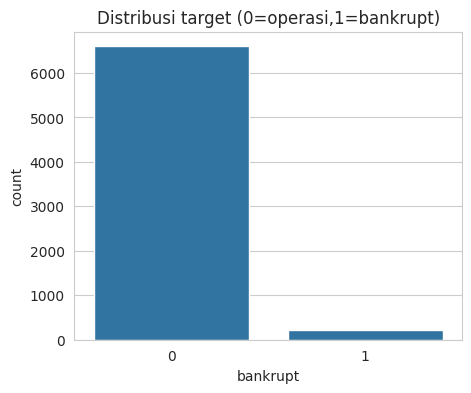

Top 10 fitur (abs corr) terhadap target:


,bankrupt
bankrupt,1.000000
net_income_to_total_assets,0.315457
roa(a)_before_interest_and_%_after_tax,0.282941
roa(b)_before_interest_and_depreciation_after_tax,0.273051
roa(c)_before_interest_and_depreciation_before_interest,0.260807
net_worth/assets,0.250161
debt_ratio_%,0.250161
persistent_eps_in_the_last_four_seasons,0.219560
retained_earnings_to_total_assets,0.217779
net_profit_before_tax/paid-in_capital,0.207857


Top features for plots: ['net_income_to_total_assets', 'roa(a)_before_interest_and_%_after_tax', 'roa(b)_before_interest_and_depreciation_after_tax', 'roa(c)_before_interest_and_depreciation_before_interest', 'net_worth/assets', 'debt_ratio_%']


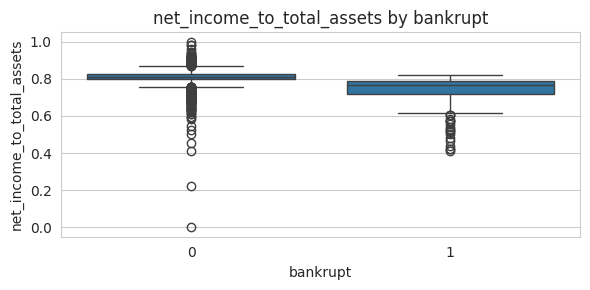

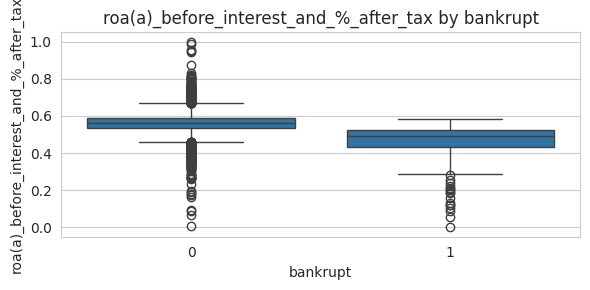

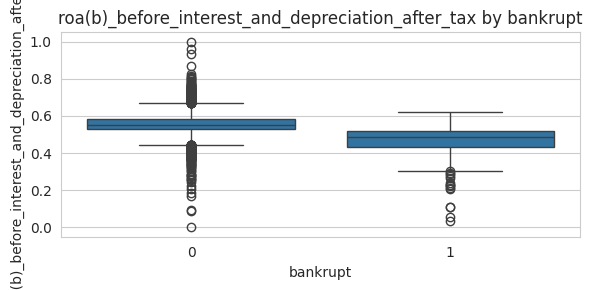

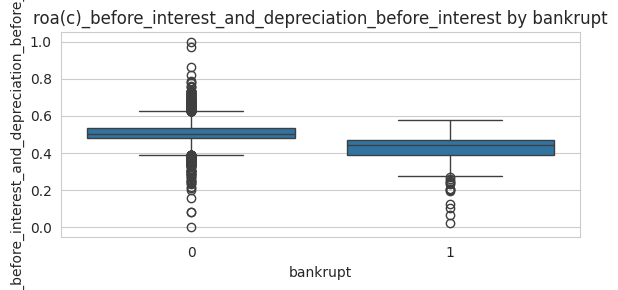

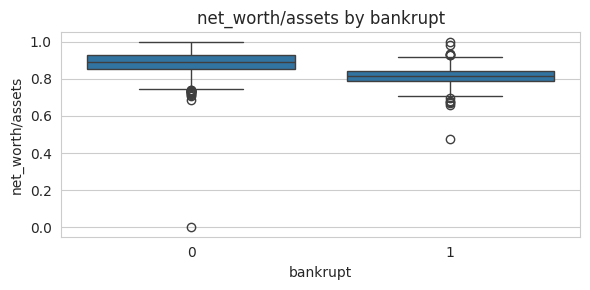

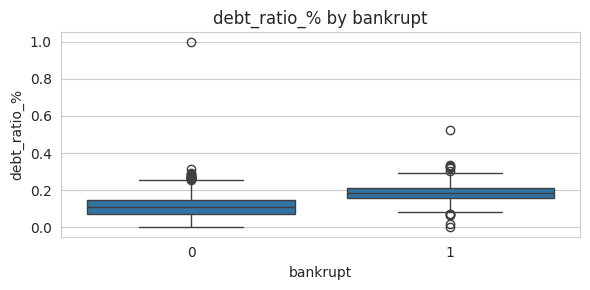

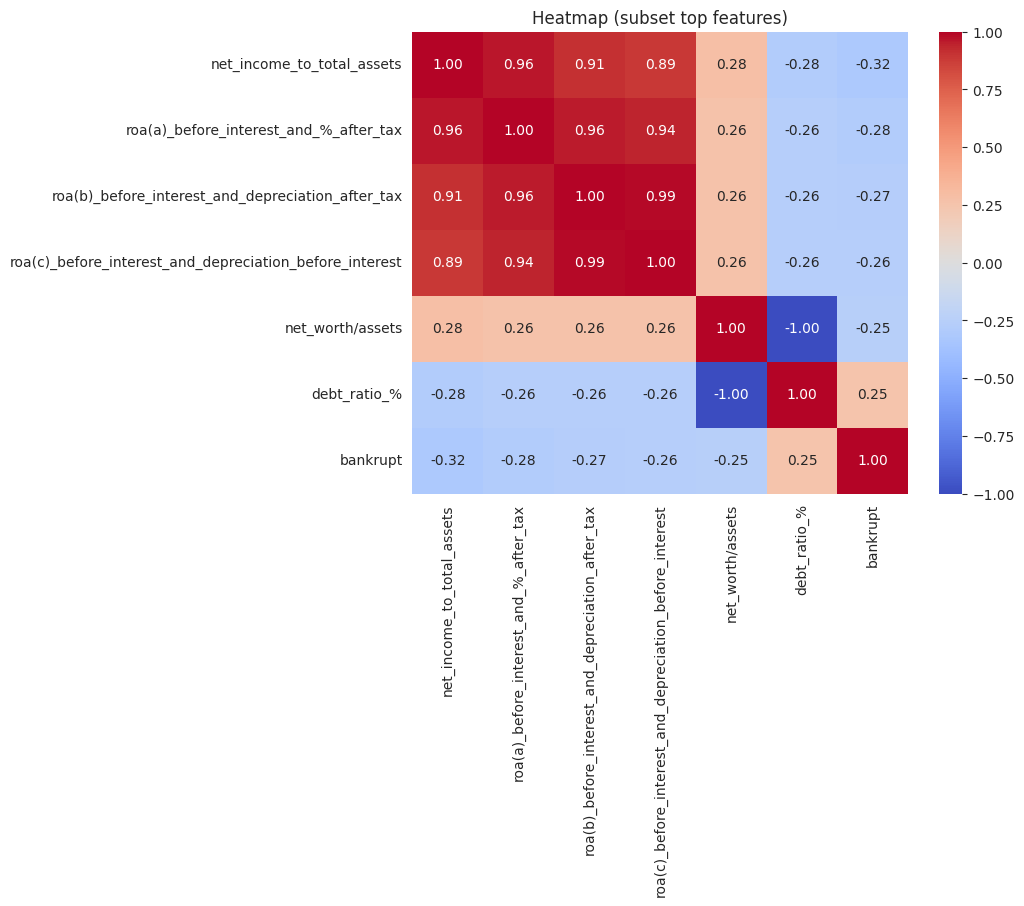

In [6]:
# Exploratory plots
plt.figure(figsize=(5,4))
sns.countplot(x=target_col, data=df)
plt.title('Distribusi target (0=operasi,1=bankrupt)')
plt.show()

# Numeric cols
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in num_cols: num_cols.remove(target_col)

# Korelasi vs target (abs)
corr_with_target = df[num_cols + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
print("Top 10 fitur (abs corr) terhadap target:")
display(corr_with_target.head(11))

top_feats = corr_with_target.index[1:7].tolist()
print("Top features for plots:", top_feats)

# Boxplots untuk tiap fitur terhadap target
for col in top_feats:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=target_col, y=col, data=df)
    plt.title(f'{col} by {target_col}')
    plt.tight_layout()
    plt.show()

# Pairwise heatmap kecil (top 6)
plt.figure(figsize=(8,6))
sns.heatmap(df[top_feats + [target_col]].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Heatmap (subset top features)')
plt.show()


In [7]:
# DAta Cleaning
missing = df.isnull().sum().sort_values(ascending=False)
print("Missing (top):")
display(missing[missing>0].head(20))


thresh = 0.5 * len(df)
drop_cols = missing[missing > thresh].index.tolist()
if drop_cols:
    print("Dropping columns with >50% missing:", drop_cols)
    df = df.drop(columns=drop_cols)


num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in num_cols: num_cols.remove(target_col)
imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

# Check balance
print("Class counts:", df[target_col].value_counts())
print("Class distribution:", df[target_col].value_counts(normalize=True))


Missing (top):


,0


Class counts: bankrupt
0    6599
1     220
Name: count, dtype: int64
Class distribution: bankrupt
0    0.967737
1    0.032263
Name: proportion, dtype: float64


In [8]:
# Split features/target and train-test (stratify)
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class dist:", y_train.value_counts(normalize=True))


Train shape: (5455, 95) Test shape: (1364, 95)
Train class dist: bankrupt
0    0.967736
1    0.032264
Name: proportion, dtype: float64


In [9]:
# Modelling: Random Forest (SMOTE)
smote = SMOTE(random_state=42)
scaler = StandardScaler()
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')

pipe_rf = ImbPipeline(steps=[
    ('smote', smote),
    ('scaler', scaler),
    ('clf', rf)
])

pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:,1]

print("Random Forest classification report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))


Random Forest classification report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.40      0.61      0.49        44

    accuracy                           0.96      1364
   macro avg       0.69      0.79      0.73      1364
weighted avg       0.97      0.96      0.96      1364

ROC AUC: 0.9400482093663911


In [10]:
# Decision Tree baseline
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=6)
pipe_dt = ImbPipeline([('smote', smote), ('scaler', scaler), ('clf', dt)])
pipe_dt.fit(X_train, y_train)
y_pred_dt = pipe_dt.predict(X_test)
y_proba_dt = pipe_dt.predict_proba(X_test)[:,1]

print("Decision Tree classification report:")
print(classification_report(y_test, y_pred_dt))
print("ROC AUC:", roc_auc_score(y_test, y_proba_dt))


Decision Tree classification report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1320
           1       0.17      0.66      0.27        44

    accuracy                           0.89      1364
   macro avg       0.58      0.78      0.61      1364
weighted avg       0.96      0.89      0.92      1364

ROC AUC: 0.8505853994490359


In [11]:
# ANN  — resample train
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
sc_ann = StandardScaler()
X_train_res_s = sc_ann.fit_transform(X_train_res)
X_test_s = sc_ann.transform(X_test)

from tensorflow.keras import models, layers, callbacks

ann = models.Sequential([
    layers.Input(shape=(X_train_res_s.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = ann.fit(X_train_res_s, y_train_res, validation_split=0.15, epochs=100, batch_size=32, callbacks=[es], verbose=1)

y_proba_ann = ann.predict(X_test_s).ravel()
y_pred_ann = (y_proba_ann > 0.5).astype(int)

print("ANN classification report:")
print(classification_report(y_test, y_pred_ann))
print("ROC AUC:", roc_auc_score(y_test, y_proba_ann))


Epoch 1/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9166 - loss: 0.3607 - val_AUC: 0.0000e+00 - val_loss: 0.2936
Epoch 2/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9736 - loss: 0.2027 - val_AUC: 0.0000e+00 - val_loss: 0.1722
Epoch 3/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9767 - loss: 0.1785 - val_AUC: 0.0000e+00 - val_loss: 0.1039
Epoch 4/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9878 - loss: 0.1292 - val_AUC: 0.0000e+00 - val_loss: 0.0965
Epoch 5/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9882 - loss: 0.1194 - val_AUC: 0.0000e+00 - val_loss: 0.0569
Epoch 6/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9914 - loss: 0.1046 - val_AUC: 0.0000e+00 - val_loss: 0.0623
Epoch 7/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9935 - loss: 0.0897 - val_AUC: 0.0000e+00 - val_loss: 0.0596
Epoch 8/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9944 - loss: 0.0761 - val_AUC: 0.0000e+00 - val_loss: 0.0296
Epoch 9/100
281/

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.40      0.61      0.49        44

    accuracy                           0.96      1364
   macro avg       0.69      0.79      0.73      1364
weighted avg       0.97      0.96      0.96      1364

ROC AUC: 0.9400482093663911


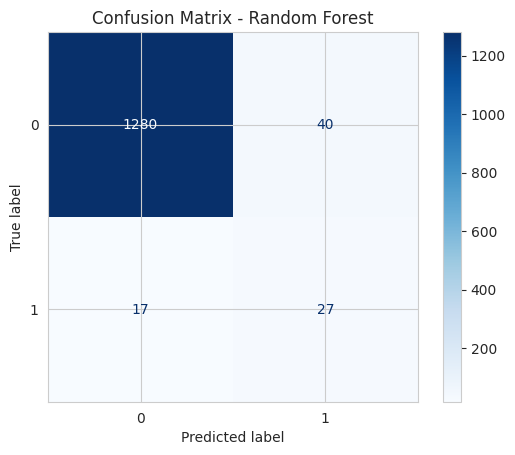

--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1320
           1       0.17      0.66      0.27        44

    accuracy                           0.89      1364
   macro avg       0.58      0.78      0.61      1364
weighted avg       0.96      0.89      0.92      1364

ROC AUC: 0.8505853994490359


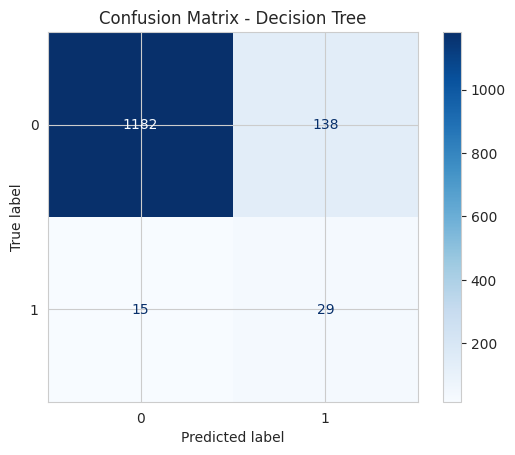

--- ANN ---
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1320
           1       0.32      0.48      0.39        44

    accuracy                           0.95      1364
   macro avg       0.65      0.72      0.68      1364
weighted avg       0.96      0.95      0.96      1364

ROC AUC: 0.8494318181818181


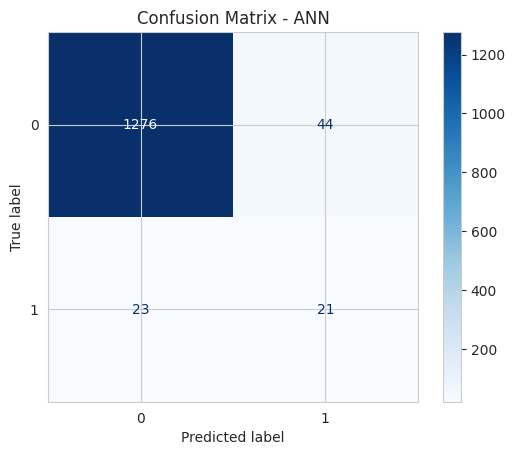

In [12]:
# Evaluation: Confusion Matrix & metrics helper
from sklearn.metrics import ConfusionMatrixDisplay

def eval_model(y_true, y_pred, y_proba, name):
    print(f"--- {name} ---")
    print(classification_report(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_proba))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

eval_model(y_test, y_pred_rf, y_proba_rf, "Random Forest")
eval_model(y_test, y_pred_dt, y_proba_dt, "Decision Tree")
eval_model(y_test, y_pred_ann, y_proba_ann, "ANN")


Top 20 Feature Importance (RF):


,feature,importance
85,net_income_to_total_assets,0.056747
39,borrowing_dependency,0.054777
18,persistent_eps_in_the_last_four_seasons,0.053795
7,after-tax_net_interest_rate,0.052378
9,continuous_interest_rate_(after_tax),0.049658
67,retained_earnings_to_total_assets,0.040112
37,net_worth/assets,0.034259
90,liability_to_equity,0.033629
36,debt_ratio_%,0.031039
89,net_income_to_stockholder's_equity,0.028683


SHAP Values shape: (1364, 95, 2)
X_test_scaled shape: (1364, 95)


<Figure size 1000x600 with 0 Axes>

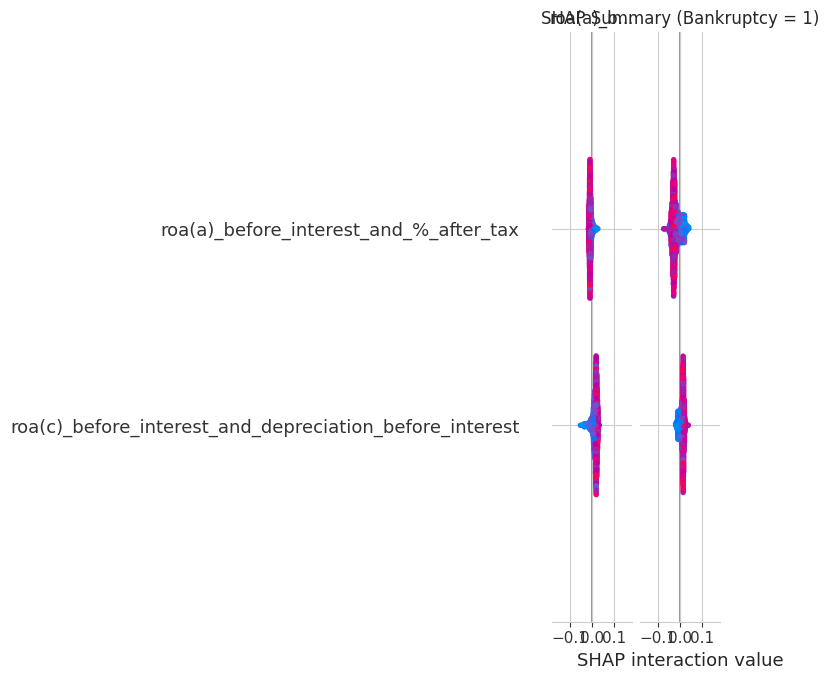


Top 5 Fitur berdasarkan SHAP:


,feature,mean_abs_shap
78,equity_to_long-term_liability,0.035305
79,cash_flow_to_total_assets,0.035305
18,persistent_eps_in_the_last_four_seasons,0.032234
19,cash_flow_per_share,0.032234
14,tax_rate_(a),0.027154


In [13]:
#  Explainability: Feature Importance + SHAP (Robust & Stable)


rf_model = pipe_rf.named_steps['clf']
feat_imp = rf_model.feature_importances_
feat_names = X_train.columns

feat_df = pd.DataFrame({'feature': feat_names, 'importance': feat_imp})
feat_df = feat_df.sort_values('importance', ascending=False)

print("Top 20 Feature Importance (RF):")
display(feat_df.head(20))


explainer = shap.TreeExplainer(rf_model)

X_test_scaled = pipe_rf.named_steps['scaler'].transform(X_test)
feature_names = X_test.columns.tolist()


shap_obj = explainer(X_test_scaled)

shap_arr = shap_obj.values

print("SHAP Values shape:", shap_arr.shape)
print("X_test_scaled shape:", X_test_scaled.shape)


plt.figure(figsize=(10,6))
shap.summary_plot(shap_arr, X_test_scaled, feature_names=feature_names, show=False)
plt.title("SHAP Summary (Bankruptcy = 1)")
plt.show()


mean_abs_shap = np.mean(np.abs(shap_arr), axis=0)


mean_abs_shap = np.array(mean_abs_shap).ravel()


min_len = min(len(feature_names), len(mean_abs_shap))
feature_names = feature_names[:min_len]
mean_abs_shap = mean_abs_shap[:min_len]

imp_shap_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

print("\nTop 5 Fitur berdasarkan SHAP:")
display(imp_shap_df.head(5))


In [14]:
top5_shap = imp_shap_df.head(5)

In [15]:
# Save models & SHAP results
joblib.dump(pipe_rf, 'rf_smote_pipeline.joblib')
ann.save('ann_model.h5')
imp_shap_df.head(50).to_csv('feature_shap_mean_abs.csv', index=False)
top5_shap.to_csv('top5_features_shap.csv', index=False)

print("Saved: rf_smote_pipeline.joblib, ann_model.h5, top5_features_shap.csv")


Saved: rf_smote_pipeline.joblib, ann_model.h5, top5_features_shap.csv
